In [64]:
# based on https://github.com/jacobgil/keras-dcgan/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Reshape, Activation, Flatten,
    BatchNormalization, UpSampling2D, Conv2D, MaxPooling2D
)


def generator_model():
    model = Sequential([
        Dense(input_dim=100, units=1024, activation='tanh'),
        Dense(128*7*7),
        BatchNormalization(),
        Activation('tanh'),
        Reshape((7, 7, 128), input_shape=(128*7*7,)),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (5, 5), padding='same'),
        Activation('tanh'),
        UpSampling2D(size=(2, 2)),
        Conv2D(1, (5, 5), padding='same'),
        Activation('tanh'),
    ])
    return model

In [65]:
g = generator_model()
g.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dense_19 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_5 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_27 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)      

In [2]:
def discriminator_model():
    model = Sequential([  
        Conv2D(
            64,
            (5, 5),
            padding='same',
            input_shape=(28, 28, 1)
        ),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5)),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(1024),
        Activation('tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [3]:
def chain_generator_discriminator(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

In [4]:
import math

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


In [10]:
!mkdir drive/'My Drive'/GAN

In [20]:
from tqdm.notebook import trange
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD
import numpy as np
from PIL import Image


def train(batch_size):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    # X_train = X_train.reshape((X_train.shape, 1) + X_train.shape[1:])
    d = discriminator_model()
    g = generator_model()
    d_on_g = chain_generator_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    nbatches = X_train.shape[0] // batch_size
    generator_losses = []
    discriminator_losses = []
    for epoch in trange(100):
        print("Epoch {}".format(epoch))
        for index in trange(nbatches):
            noise = np.random.uniform(-1, 1, size=(batch_size, 100))
            image_batch = X_train[index*batch_size:(index+1)*batch_size]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(
                    image.astype(np.uint8)
                ).save(r'drive/My Drive/GAN/{}_{}.png'.format(epoch, index))
            X = np.concatenate(
                (image_batch, generated_images)
            )
            y = np.array(
                [1] * batch_size + [0] * batch_size
            )  # concatenated true (1) and fake (0)
            d_loss = d.train_on_batch(X, y)
            # print("batch %d d_loss : %f" % (index, d_loss))
            discriminator_losses.append(d_loss)
            noise = np.random.uniform(-1, 1, (batch_size, 100))
            d.trainable = False
            targets = np.array([1] * batch_size)  # log(1−D(G(x)))
            g_loss = d_on_g.train_on_batch(noise, targets)
            d.trainable = True
            generator_losses.append(g_loss)
            # print("batch %d g_loss : %f" % (index, g_loss))
        if index % 10 == 0 and index > 0:
            g.save_weights(r'drive/My Drive/GAN/generator.tf', True)
            d.save_weights(r'drive/My Drive/GAN/discriminator.tf', True)
                
    return discriminator_losses, generator_losses

In [21]:
batch_size = 100
discriminator_losses, generator_losses = train(batch_size)

Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60



Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80



Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95



Epoch 96



Epoch 97



Epoch 98



Epoch 99


In [59]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}

matplotlib.rc('font', **font)

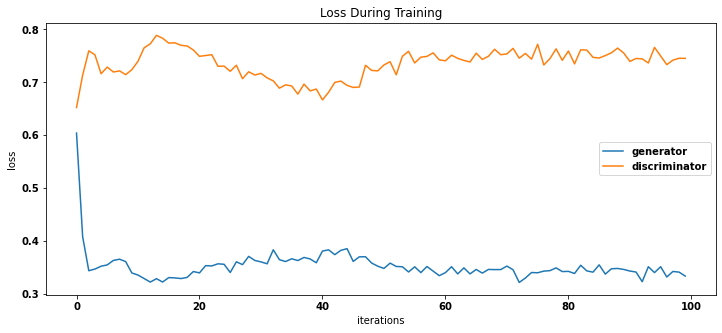

In [60]:
%matplotlib inline

plt.figure(figsize=(12, 5))
plt.title("Loss During Training")
plt.plot(np.array(generator_losses).reshape(batch_size, -1)[:, 0], label="generator")
plt.plot(np.array(discriminator_losses).reshape(batch_size, -1)[:, 0], label="discriminator")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()

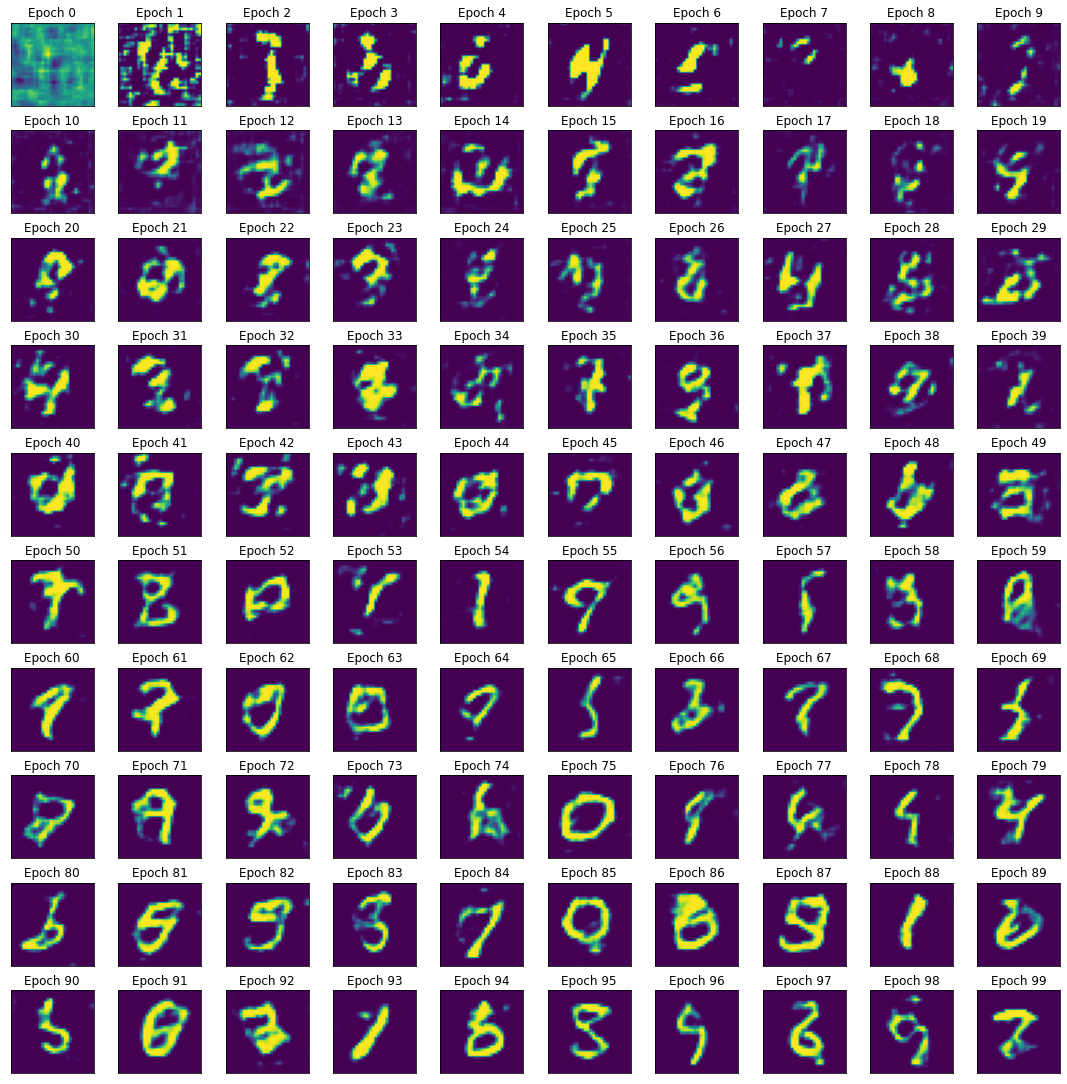

In [61]:
nrows = 10
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
i = 0
for row in range(nrows):
  for col in range(ncols):
    ax = axes[row, col]
    A = plt.imread(
        'drive/My Drive/GAN/{}_{}.png'.format(i, 0)
    )[:30, :30]
    ax.imshow(A)
    ax.set_title('Epoch {}'.format(i))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

fig.tight_layout(pad=.5)

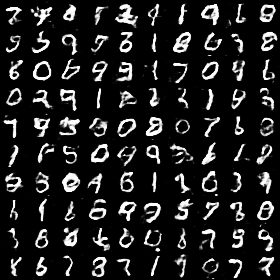

In [31]:
A